In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, accuracy_score

# Функция сигмоиды
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Логистическая регрессия
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities > threshold).astype(int)

In [2]:
np.random.seed(42)

# Параметры
mu_positive = [2, 2]
mu_negative = [0, 0]
cov_matrix = [[1, 0.5], [0.5, 1]]

# Генерация данных
positive_samples = np.random.multivariate_normal(mu_positive, cov_matrix, 30)
negative_samples = np.random.multivariate_normal(mu_negative, cov_matrix, 30)

X = np.vstack((positive_samples, negative_samples))
y = np.hstack((np.ones(30), np.zeros(30)))

# Разделение данных
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

train_size = len(X) // 3
X_train, X_val, X_test = X[:train_size], X[train_size:2*train_size], X[2*train_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:2*train_size], y[2*train_size:]


In [3]:
# Создание и обучение модели
model = LogisticRegression(lr=0.1, epochs=1000)
model.fit(X_train, y_train)

# Предсказания для валидационной выборки
probs_val = model.predict_proba(X_val)


In [4]:
thresholds = np.linspace(0, 1, 100)
best_threshold = 0
best_recall = 0

for t in thresholds:
    y_pred = (probs_val > t).astype(int)
    recall = recall_score(y_val, y_pred)
    if recall >= 0.6:
        best_threshold = t
        break

print(f"Оптимальный порог: {best_threshold}")


Оптимальный порог: 0.0


In [5]:
# Предсказания для тестовой выборки
y_pred_test = model.predict(X_test, threshold=best_threshold)

# Метрики
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

probs_test = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probs_test)
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"Матрица ошибок:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC: {roc_auc}")


Accuracy: 0.55
Матрица ошибок:
[[ 0  9]
 [ 0 11]]
Precision: 0.55
Recall: 1.0
ROC-AUC: 0.9494949494949494


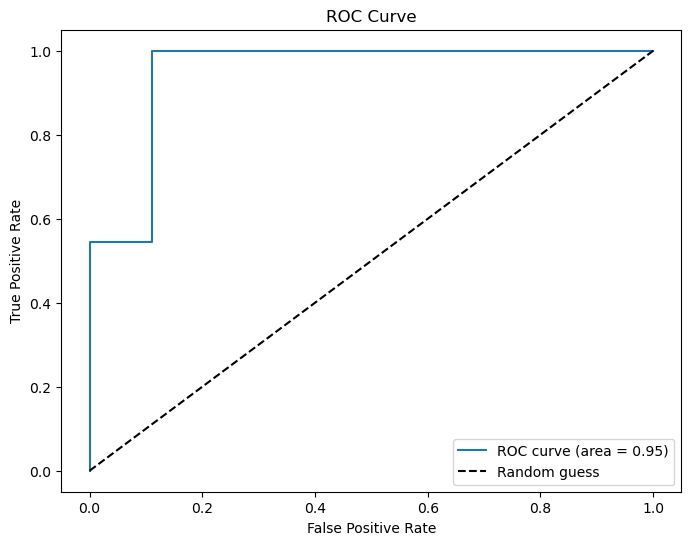

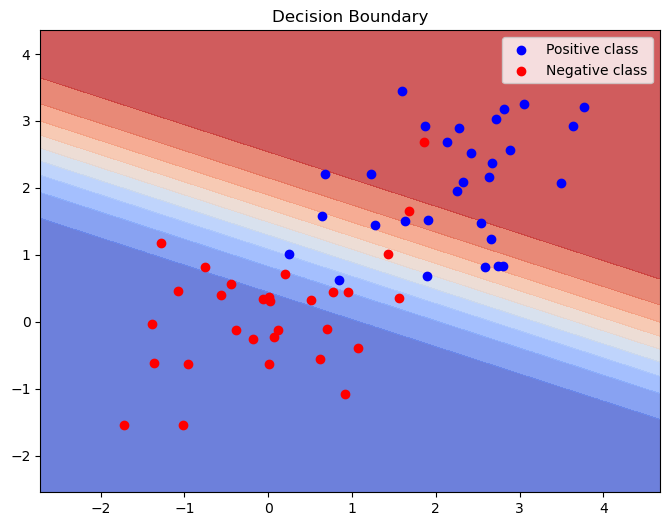

In [6]:
# ROC-кривая
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Разделяющая поверхность
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, alpha=0.8, levels=np.linspace(0, 1, 11), cmap="coolwarm")
plt.scatter(*positive_samples.T, color="blue", label="Positive class")
plt.scatter(*negative_samples.T, color="red", label="Negative class")
plt.title("Decision Boundary")
plt.legend()
plt.show()
